In [60]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization
using ITensors
using Colors, ColorSchemes

Random.seed!(1234);

In [61]:
using Pkg
Pkg.status("MPSTime")


Status `C:\Users\Lukas Robinson\.julia\environments\v1.11\Project.toml`
  [add04bee] MPSTime v0.2.0-DEV `C:\Users\Lukas Robinson\MPSTime.jl`


In [62]:
ts_params = Dict(
    :ts_type => :ar,
    :ts_length => 4000,
    :ts_test_length => 200,
    :ts_split => nothing,
    # :ts_preprocess => :diff, :zscore, :minmax, 
    
    :mps_N => 3,
    :mps_d => 15,
    :mps_chi => 100,
    :mps_sweeps => 50,

    # Sine Related Metrics
    :s_freq => 0.005,
    :s_amp => 1.0,
    :s_phase => 0.0,
    :s_sigma => 0.0,

    #AR(n) Related Metrics
    :ar_phi => [0.0],
    :ar_phi_range => [-0.99, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 0.99 ],
    # :ar_phi => [1.0,0.0],
    :ar_sigma => 0.05,

    #Logistic Map Related Metrics
    :lm_r => 4,
    :lm_x0 => 0.2

);

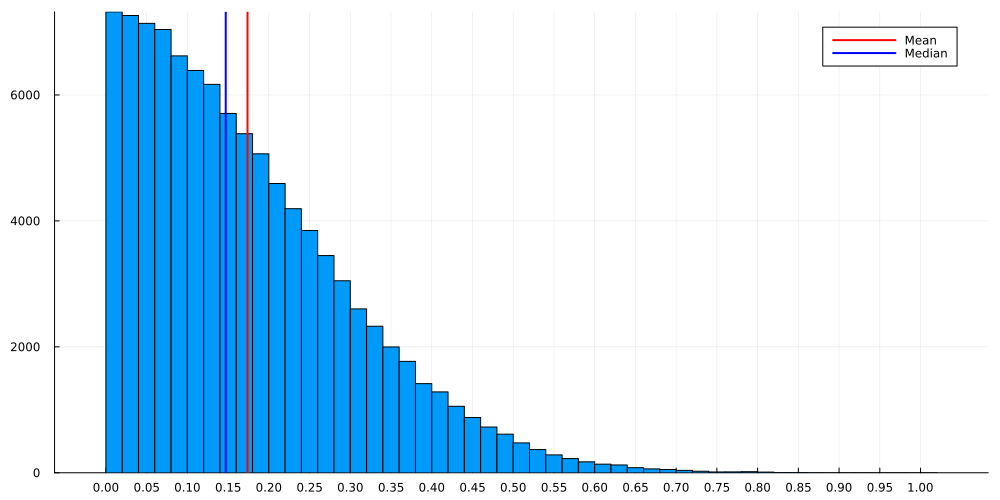

In [63]:

data_min = minimum(data)
data_max = maximum(data)

# Min-max scaling function
min_max_scale(x) = (x .- data_min) ./ (data_max - data_min)

# Apply scaling
scaled_data = min_max_scale(data)

mean_val = mean(scaled_data)
median_val = median(scaled_data)

# # Estimate mode by finding the bin with the highest frequency
# counts, edges = histogram(data, bins=50, plot=false)
# bin_centers = (edges[1:end-1] + edges[2:end]) ./ 2
# mode_val = bin_centers[argmax(counts)]

# Plot histogram
histogram(scaled_data, bins = 50, xticks = 0:0.05:1, label = "", legend = :topright, size = (1000,500))

# Add lines for mean, median, and mode
vline!([mean_val], label = "Mean", lw=2, lc=:red)
vline!([median_val], label = "Median", lw=2, lc=:blue)
# vline!([mode_val], label = "Mode", lw=2, lc=:green)

In [64]:
# Load from file
all_outputs = open("xxy_T_phis_sigma=1.jls", "r") do io
    deserialize(io)
end

Dict{Tuple{Float64, Int64}, NamedTuple} with 153 entries:
  (-0.5, 25)    => (time_points = 1:200, predicted = [-0.249887, 0.457166, 0.36…
  (-0.75, 5)    => (time_points = 1:200, predicted = [-0.359478, 0.52365, -0.01…
  (0.25, 3)     => (time_points = 1:200, predicted = [-0.0154049, 0.367271, 0.3…
  (-0.99, 2000) => (time_points = 1:200, predicted = [0.155047, -0.210588, 0.19…
  (-0.25, 75)   => (time_points = 1:200, predicted = [-0.143124, 0.406794, -0.2…
  (0.0, 3)      => (time_points = 1:200, predicted = [-0.0578966, 0.383111, 0.2…
  (0.5, 500)    => (time_points = 1:200, predicted = [0.0112323, 0.337926, -0.1…
  (0.75, 100)   => (time_points = 1:200, predicted = [0.143313, 0.361217, -0.11…
  (0.99, 100)   => (time_points = 1:200, predicted = [0.332768, 0.38934, 0.3866…
  (-0.99, 1500) => (time_points = 1:200, predicted = [0.155047, -0.210588, 0.20…
  (-0.25, 2000) => (time_points = 1:200, predicted = [-0.143124, 0.406794, -0.1…
  (0.5, 3)      => (time_points = 1:200, predicted 

In [65]:
collect(keys(all_outputs))

153-element Vector{Tuple{Float64, Int64}}:
 (-0.5, 25)
 (-0.75, 5)
 (0.25, 3)
 (-0.99, 2000)
 (-0.25, 75)
 (0.0, 3)
 (0.5, 500)
 (0.75, 100)
 (0.99, 100)
 (-0.99, 1500)
 ⋮
 (-0.25, 5)
 (-0.99, 75)
 (0.75, 3)
 (0.25, 500)
 (0.99, 3)
 (0.5, 1500)
 (0.0, 500)
 (-0.5, 250)
 (-0.5, 750)

In [77]:
all_outputs[(0,1)]

(time_points = 1:200,
 predicted = [-0.057896602111281115, 0.3831105072611427, 0.12822935905858035, 0.3847005159071645, 0.3758646049128333, 0.2808409585976776, 0.3122186144295256, 0.31226271514046283, 0.18127874212765555, 0.11948544626643079  …  0.19373643674948565, 0.6116265643071854, 0.6061759599556084, 0.2044912713658854, 0.19389289129216303, 0.19292083028040602, -0.1508912543136547, 0.3287985268197039, 0.017440746984435027, 0.2858778770128881],
 actual = [-0.057896602111281115, 0.3831105072611427, -0.26210969297687503, -0.076766730176003, 0.46179573242908245, 0.03522565708946268, 0.2065123397665889, 0.1544168569168678, 0.3048178362641518, -0.2192080137315907  …  -0.05940564278886429, -0.43155360379628693, 0.7859058909851477, 0.31100760073298606, -0.14081139976372903, -0.30968576758066657, -0.6375695092995031, -0.24909706455177583, 0.42534489305046463, -0.03504207966481099],
 mps_prderr = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

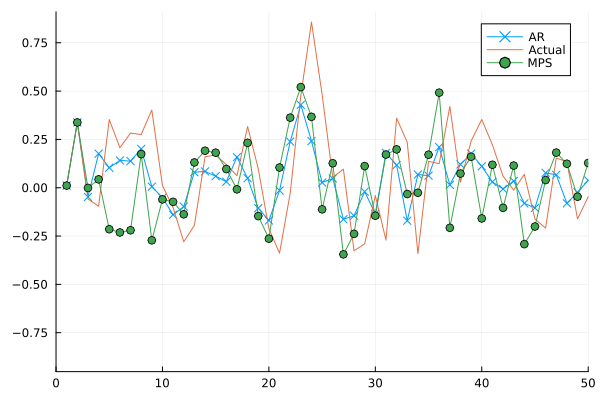

In [89]:
plot(all_outputs[(0.5,3000)][:ar_predictions], label = "AR", marker = :x, xlims = [0,50])
plot!(all_outputs[(0.5,3000)][:actual], label = "Actual")
plot!(all_outputs[(0.5,3000)][:predicted], label = "MPS", marker = :o)

In [67]:
# Create a new dictionary to store enhanced results
enhanced_outputs = Dict{Tuple{Float64,Int64},NamedTuple}()

for (key, output) in all_outputs
    # Extract all prediction vectors and actual values
    actual = output.actual
    preds = (
        predicted = output.predicted,
        mean_pred = output.mean_predictions,
        ar_pred = output.ar_predictions
    )
    
    # Calculate MAEs for each prediction type
    maes = (
        predicted_mae = mean(abs.(preds.predicted .- actual)),
        mean_pred_mae = mean(abs.(preds.mean_pred .- actual)),
        ar_pred_mae = mean(abs.(preds.ar_pred .- actual))
    )
    
    # Merge with existing metrics
    new_metrics = merge(output.metrics, maes)
    
    # Create new NamedTuple with all original fields plus new MAEs
    enhanced_outputs[key] = merge(
        output,
        (metrics = new_metrics,)
    )
end

In [68]:
phi_values = sort(unique(k[1] for k in keys(all_outputs)))
train_lengths = sort(unique(k[2] for k in keys(all_outputs)))
losses = sort(unique(v.metrics.model_mae for v in values(all_outputs)))

153-element Vector{Float64}:
 0.03806118704338602
 0.03834060319064462
 0.0388043680982749
 0.04524170511083278
 0.05136262461276497
 0.05247037611677135
 0.05287331058127826
 0.05315834489707991
 0.05379702785996251
 0.05497111943399932
 ⋮
 0.3666564998450909
 0.36677330217986387
 0.3768298028154338
 0.38293705940414474
 0.3923422657469858
 0.39319009991860704
 0.41122808633687613
 0.4129772107396941
 0.44668149395631945

In [69]:
phi_values = sort(unique(k[1] for k in keys(enhanced_outputs)))
train_lengths = sort(unique(k[2] for k in keys(enhanced_outputs)))
loss_matrix_model = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_model[i, j] = enhanced_outputs[(phi, len)].metrics.predicted_mae
    else
        loss_matrix_model[i, j] = NaN  # Missing data
    end
end

loss_matrix_mean = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_mean[i, j] = enhanced_outputs[(phi, len)].metrics.mean_pred_mae
    else
        loss_matrix_mean[i, j] = NaN  # Missing data
    end
end

loss_matrix_ar = zeros(length(train_lengths), length(phi_values))

for (i, len) in enumerate(train_lengths), (j, phi) in enumerate(phi_values)
    if haskey(enhanced_outputs, (phi, len))
        loss_matrix_ar[i, j] = enhanced_outputs[(phi, len)].metrics.ar_pred_mae
    else
        loss_matrix_ar[i, j] = NaN  # Missing data
    end
end

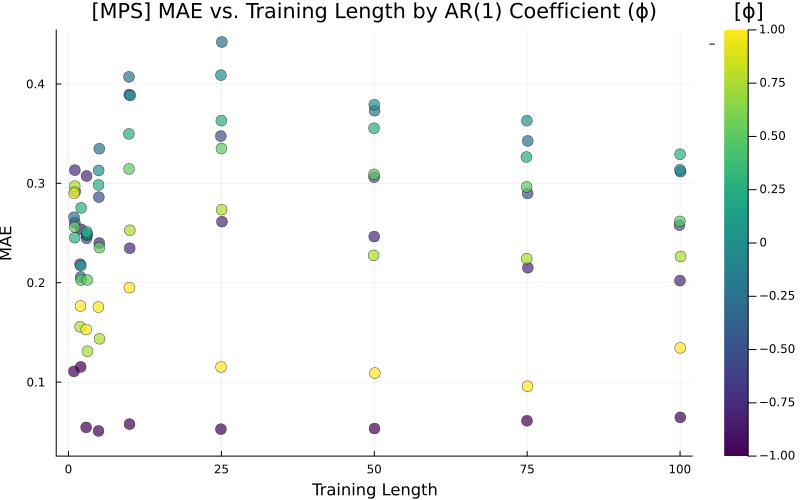

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [92]:
gr()

# Set layout: main plot and dummy heatmap for colorbar
layout = @layout [a{0.95w} b]
cmap = cgrad(:viridis)

# Create the main scatter plot
plt = plot(
    xlabel = "Training Length",
    ylabel = "MAE",
    legend = false,
    size = (800, 500),
    # yscale = :log10
    # ylim = (0,0.15),
    # yticks = 0:0.02:0.15
    xlim = (-2, 102)
)

# Get sorted unique phi values
phi_values = sort(unique([k[1] for k in keys(enhanced_outputs)]))
num_phis = length(phi_values)

# Convert color scheme to palette
color_palette = cmap[1:num_phis]

# Jitter
train_lengths_all = [k[2] for k in keys(enhanced_outputs)]
jitter_strength = 0.25 * minimum(train_lengths_all)

# Plot each phi
for (i, phi) in enumerate(phi_values)
    filtered_entries = [(k[2], v.metrics.predicted_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    train_lengths = [x[1] for x in filtered_entries]
    losses = [x[2] for x in filtered_entries]

    sort_order = sortperm(train_lengths)
    train_lengths = train_lengths[sort_order]
    losses = losses[sort_order]

    jittered_lengths = train_lengths .+ jitter_strength .* (rand(length(train_lengths)) .- 0.5)
    color_value = (phi - minimum(phi_values)) / (maximum(phi_values) - minimum(phi_values))

    scatter!(
        plt,
        jittered_lengths,
        losses,
        color = cmap[color_value],
        markersize = 6,
        alpha = 0.7,
        markerstrokewidth = 0.5,
        label = "",
        title = "[MPS] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    )

    # filtered_entries = [(k[2], v.metrics.mean_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = cmap[color_value],
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = "",
    #     title = "[Mean] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    # )

    # filtered_entries = [(k[2], v.metrics.ar_pred_mae) for (k, v) in enhanced_outputs if k[1] ≈ phi]
    # train_lengths = [x[1] for x in filtered_entries]
    # losses = [x[2] for x in filtered_entries]

    # scatter!(
    #     plt,
    #     jittered_lengths,
    #     losses,
    #     color = cmap[color_value],
    #     markersize = 6,
    #     alpha = 0.7,
    #     markerstrokewidth = 0.5,
    #     label = "",
    #     title = "[AR] MAE vs. Training Length by AR(1) Coefficient (ϕ)"
    # )
end

# Dummy heatmap for colorbar
dummy_heatmap = heatmap(
    [0 0; 1 1],  # dummy 2x2 data
    clims = (-1, 1),
    framestyle = :none,
    c = cmap,
    lims = (-1, 0),
    title = "     [ϕ]"
)

# Combine plots with layout
final_plot = plot(plt, dummy_heatmap, layout = layout)

display(final_plot)

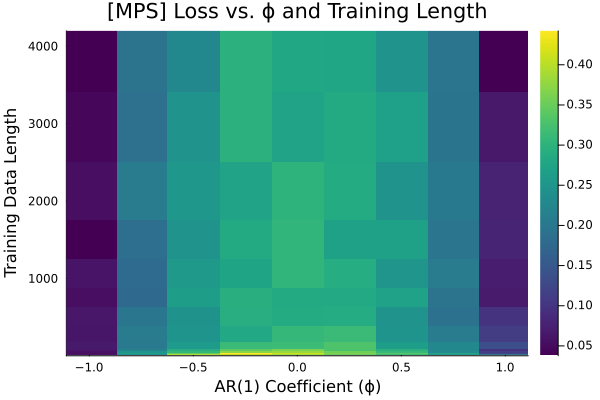

In [95]:
heatmap(phi_values, train_lengths, loss_matrix_model,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[MPS] Loss vs. ϕ and Training Length",
        color = :viridis)

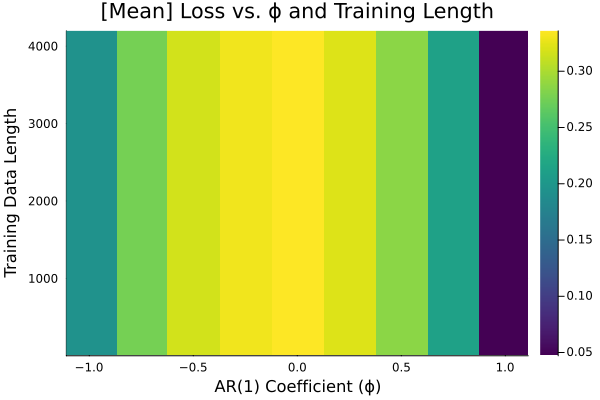

In [94]:
heatmap(phi_values, train_lengths, loss_matrix_mean,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[Mean] Loss vs. ϕ and Training Length",
        color = :viridis)

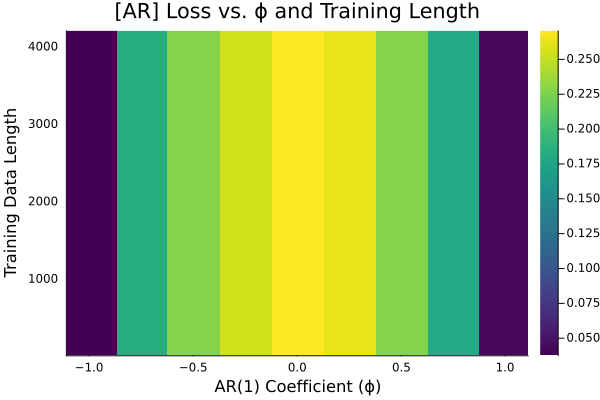

In [93]:
heatmap(phi_values, train_lengths, loss_matrix_ar,
        xlabel = "AR(1) Coefficient (ϕ)",
        ylabel = "Training Data Length",
        title = "[AR] Loss vs. ϕ and Training Length",
        color = :viridis)